In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
warnings.filterwarnings(action='ignore')


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)

import sklearn
from sklearn.neighbors import KNeighborsRegressor

from utils.preprocess_utils import *


In [3]:
# load data
time_data = pd.read_csv('data/original/time_data.txt', sep  = ' ') 
time_data = df2npy(time_data)

# 아침 점심 저녁 분리
morning_data = time_data[:,2,:,:]
lunch_data = time_data[:,1,:,:]
evening_data = time_data[:,0,:,:]

# split time data
# train_validation_test
# scaling
# make intput, output window
morning_data, train_valid_test_loc_index, m_time_scaler = split_train_valid_test(morning_data)
lunch_data, _, l_time_scaler = split_train_valid_test(lunch_data)
evening_data, _, e_time_scaler = split_train_valid_test(evening_data)

# split notime data
# notime_train, notime_valid, notime_test = notime
nontime_data = pd.read_csv('data/original/nontime_data.txt', sep = ' ')
notime, no_time_scaler = split_notime_data(nontime_data, train_valid_test_loc_index)

print('\n morning')
m_train_time, m_train_notime, m_train_y = make_time_notime_data(morning_data[0], notime)
m_valid_time, m_valid_notime, m_valid_y = make_time_notime_data(morning_data[1], notime)
m_test_time, m_test_notime, m_test_y = make_time_notime_data(morning_data[2], notime)

print('\n lunch')
l_train_time, l_train_notime, l_train_y = make_time_notime_data(lunch_data[0], notime)
l_valid_time, l_valid_notime, l_valid_y = make_time_notime_data(lunch_data[1], notime)
l_test_time, l_test_notime, l_test_y = make_time_notime_data(lunch_data[2], notime)

print('\n evening')
e_train_time, e_train_notime, e_train_y = make_time_notime_data(evening_data[0], notime)
e_valid_time, e_valid_notime, e_valid_y = make_time_notime_data(evening_data[1], notime)
e_test_time, e_test_notime, e_test_y = make_time_notime_data(evening_data[2], notime)


 morning
(9185, 20, 12)
(9185, 3)
(9185, 7, 2)
(330, 20, 12)
(330, 3)
(330, 7, 2)
(1309, 20, 12)
(1309, 3)
(1309, 7, 2)

 lunch
(9185, 20, 12)
(9185, 3)
(9185, 7, 2)
(330, 20, 12)
(330, 3)
(330, 7, 2)
(1309, 20, 12)
(1309, 3)
(1309, 7, 2)

 evening
(9185, 20, 12)
(9185, 3)
(9185, 7, 2)
(330, 20, 12)
(330, 3)
(330, 7, 2)
(1309, 20, 12)
(1309, 3)
(1309, 7, 2)


In [51]:
train_time = torch.FloatTensor(np.concatenate([m_train_time, l_train_time, e_train_time])[:,:,2:]).to(device)
train_notime = torch.FloatTensor(np.concatenate([m_train_notime, l_train_notime, e_train_notime])).to(device)
train_y = torch.FloatTensor(np.concatenate([m_train_y, l_train_y, e_train_y])).to(device)

valid_time = torch.FloatTensor(np.concatenate([m_valid_time, l_valid_time, e_valid_time])[:,:,2:]).to(device)
valid_notime = torch.FloatTensor(np.concatenate([m_valid_notime, l_valid_notime, e_valid_notime])).to(device)
valid_y = torch.FloatTensor(np.concatenate([m_valid_y, l_valid_y, e_valid_y])).to(device)

test_time = torch.FloatTensor(np.concatenate([m_test_time, l_test_time, e_test_time])[:,:,2:]).to(device)
test_notime = torch.FloatTensor(np.concatenate([m_test_notime, l_test_notime, e_test_notime])).to(device)
test_y = torch.FloatTensor(np.concatenate([m_test_y, l_test_y, e_test_y])).to(device)

In [59]:
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [60]:
m_train_time = torch.FloatTensor(l_train_time[:,:,2:]).to(device)
m_train_notime = torch.FloatTensor(l_train_notime).to(device)
m_train_y = torch.FloatTensor(l_train_y).to(device)
 
m_valid_time = torch.FloatTensor(l_valid_time[:,:,2:]).to(device)
m_valid_notime = torch.FloatTensor(l_valid_notime).to(device)
m_valid_y = torch.FloatTensor(l_valid_y).to(device)

In [30]:
m_train_time = torch.FloatTensor(m_train_time[:,:,2:]).to(device)
m_train_notime = torch.FloatTensor(m_train_notime).to(device)
m_train_y = torch.FloatTensor(m_train_y).to(device)
 
m_valid_time = torch.FloatTensor(m_valid_time[:,:,2:]).to(device)
m_valid_notime = torch.FloatTensor(m_valid_notime).to(device)
m_valid_y = torch.FloatTensor(m_valid_y).to(device)

In [53]:
# hidden state : 전달과정 중간 출력의 차원
model_trend = LSTMModel_trend(input_size = 10, hidden_size = 32, no_time_size = 3).to(device)
optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

# Train model
#####################
num_epochs  = 500
hist = np.zeros(num_epochs)

# Number of steps to unroll
look_back = 21
seq_dim =look_back - 1  

train_error = []
valid_error = []

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass
    train_trend_pred = model_trend(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,0])
    train_error.append(loss)

    valid_trend_pred = model_trend(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,0]).cpu())
    valid_error.append(valid_mse)

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

10 Epochs train MSE: 0.50953 // valid MSE: 0.21259
20 Epochs train MSE: 0.08636 // valid MSE: 0.08143
30 Epochs train MSE: 0.03640 // valid MSE: 0.04429
40 Epochs train MSE: 0.01420 // valid MSE: 0.01881
50 Epochs train MSE: 0.01091 // valid MSE: 0.01759
60 Epochs train MSE: 0.00878 // valid MSE: 0.01745
70 Epochs train MSE: 0.00762 // valid MSE: 0.01777
80 Epochs train MSE: 0.00675 // valid MSE: 0.01676
90 Epochs train MSE: 0.00621 // valid MSE: 0.01626
100 Epochs train MSE: 0.00577 // valid MSE: 0.01567
110 Epochs train MSE: 0.00538 // valid MSE: 0.01508
120 Epochs train MSE: 0.00509 // valid MSE: 0.01459
130 Epochs train MSE: 0.00485 // valid MSE: 0.01422
140 Epochs train MSE: 0.00457 // valid MSE: 0.01398
150 Epochs train MSE: 0.00438 // valid MSE: 0.01381
160 Epochs train MSE: 0.00423 // valid MSE: 0.01358
170 Epochs train MSE: 0.00410 // valid MSE: 0.01346
180 Epochs train MSE: 0.00395 // valid MSE: 0.01356
190 Epochs train MSE: 0.00390 // valid MSE: 0.01333
200 Epochs train MSE:

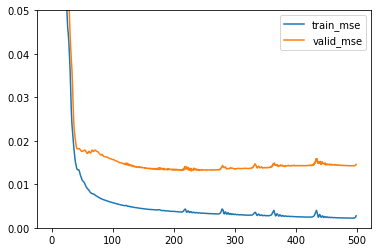

In [54]:
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.05)
plt.show()

In [62]:
# hidden state : 전달과정 중간 출력의 차원
model_trend = LSTMModel_trend(input_size = 10, hidden_size = 32, no_time_size = 3).to(device)
optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

# Train model
#####################
num_epochs  = 500
hist = np.zeros(num_epochs)

# Number of steps to unroll
look_back = 21
seq_dim =look_back - 1  

train_error = []
valid_error = []

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass
    train_trend_pred = model_trend(m_train_time, m_train_notime)
    loss = criterion(train_trend_pred, m_train_y[:,:,0])
    train_error.append(loss)

    valid_trend_pred = model_trend(m_valid_time, m_valid_notime)
    valid_mse = float(criterion(valid_trend_pred, m_valid_y[:,:,0]).cpu())
    valid_error.append(valid_mse)

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

10 Epochs train MSE: 0.51703 // valid MSE: 0.37536
20 Epochs train MSE: 0.07603 // valid MSE: 0.05027
30 Epochs train MSE: 0.02212 // valid MSE: 0.02035
40 Epochs train MSE: 0.01510 // valid MSE: 0.01201
50 Epochs train MSE: 0.00847 // valid MSE: 0.00783
60 Epochs train MSE: 0.00711 // valid MSE: 0.00673
70 Epochs train MSE: 0.00576 // valid MSE: 0.00577
80 Epochs train MSE: 0.00519 // valid MSE: 0.00597
90 Epochs train MSE: 0.00472 // valid MSE: 0.00545
100 Epochs train MSE: 0.00442 // valid MSE: 0.00526
110 Epochs train MSE: 0.00418 // valid MSE: 0.00530
120 Epochs train MSE: 0.00400 // valid MSE: 0.00524
130 Epochs train MSE: 0.00399 // valid MSE: 0.00524
140 Epochs train MSE: 0.00391 // valid MSE: 0.00530
150 Epochs train MSE: 0.00371 // valid MSE: 0.00516
160 Epochs train MSE: 0.00353 // valid MSE: 0.00512
170 Epochs train MSE: 0.00344 // valid MSE: 0.00512
180 Epochs train MSE: 0.00416 // valid MSE: 0.00514
190 Epochs train MSE: 0.00332 // valid MSE: 0.00502
200 Epochs train MSE:

In [14]:
# Train model
#####################
num_epochs  = 500
hist = np.zeros(num_epochs)

# Number of steps to unroll
look_back = 21
seq_dim =look_back - 1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass
    train_trend_pred = model_trend(m_train_time, m_train_notime)
    loss = criterion(train_trend_pred, m_train_y[:,:,0])
    train_error.append(loss)

    valid_trend_pred = model_trend(m_valid_time, m_valid_notime)
    valid_mse = float(criterion(valid_trend_pred, m_valid_y[:,:,0]).cpu())
    valid_error.append(valid_mse)

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

10 Epochs train MSE: 0.00553 // valid MSE: 0.00897
20 Epochs train MSE: 0.00364 // valid MSE: 0.00871
30 Epochs train MSE: 0.00277 // valid MSE: 0.00838
40 Epochs train MSE: 0.00255 // valid MSE: 0.00836
50 Epochs train MSE: 0.00231 // valid MSE: 0.00820
60 Epochs train MSE: 0.00221 // valid MSE: 0.00820
70 Epochs train MSE: 0.00211 // valid MSE: 0.00837
80 Epochs train MSE: 0.00204 // valid MSE: 0.00842
90 Epochs train MSE: 0.00199 // valid MSE: 0.00840
100 Epochs train MSE: 0.00193 // valid MSE: 0.00836
110 Epochs train MSE: 0.00189 // valid MSE: 0.00828
120 Epochs train MSE: 0.00185 // valid MSE: 0.00821
130 Epochs train MSE: 0.00181 // valid MSE: 0.00814
140 Epochs train MSE: 0.00178 // valid MSE: 0.00807
150 Epochs train MSE: 0.00175 // valid MSE: 0.00801
160 Epochs train MSE: 0.00173 // valid MSE: 0.00795
170 Epochs train MSE: 0.00170 // valid MSE: 0.00790
180 Epochs train MSE: 0.00168 // valid MSE: 0.00786
190 Epochs train MSE: 0.00166 // valid MSE: 0.00783
200 Epochs train MSE:

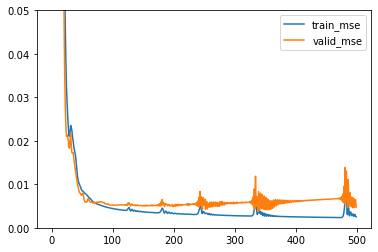

In [63]:
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.05)
plt.show()

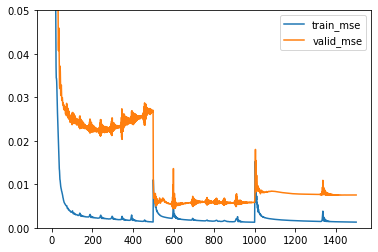

In [16]:
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.05)
plt.show()

In [3]:
def plot_predict(train_x, train_y, train_pred,
                    valid_time_x, valid_notime_x, valid_y, plot_numbers = 10):
    for i in range(plot_numbers):
        i = i*7
        plt.figure(figsize = (15, 3))
        
        plt.subplot(1,2,1)
        plt.plot(np.arange(20), train_x[i,:],   # m_train_time.cpu().detach().numpy()[i,:,-2],
                marker = 'o', color = 'black', label = 'True_input')
        plt.plot(np.arange(21,28), train_y[i],    #m_train_y[:,:,0].cpu().detach().numpy()[i],
                marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
        plt.plot(np.arange(21,28),train_pred[i],    #.cpu().detach().numpy()[i],
                color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
        
        plt.subplot(1,2,2)
        plt.plot(np.arange(20), valid_x[i:,],
                marker = 'o', color = 'black', label = 'True_input')
        plt.plot(np.arange(21,28), valid_y[i],
                marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
        plt.plot(np.arange(21,28), valid_pred[i],
                color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
        
        plt.legend()
        plt.show()


In [ ]:
plot_predict

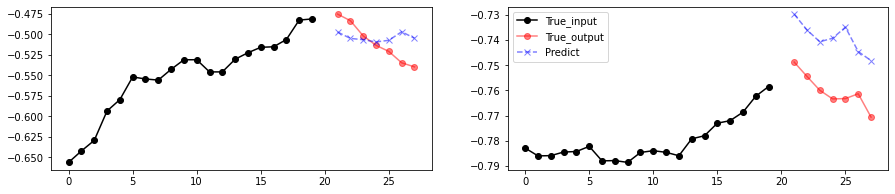

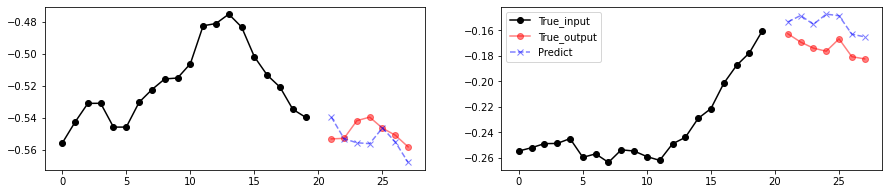

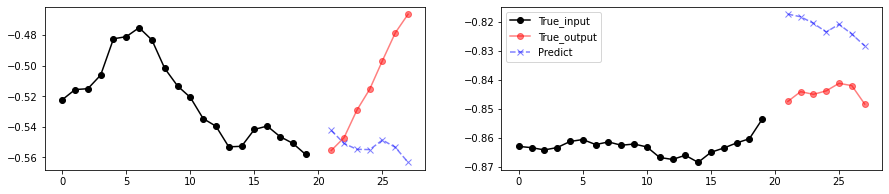

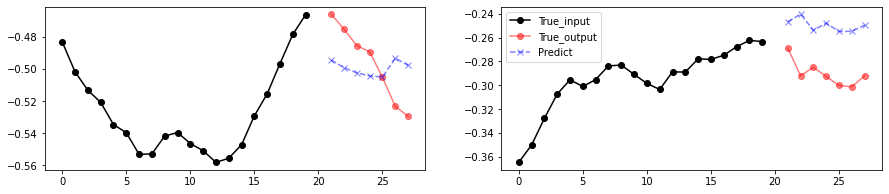

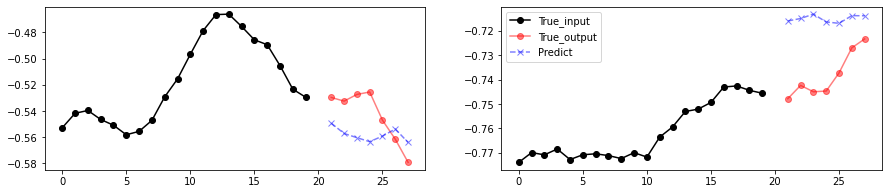

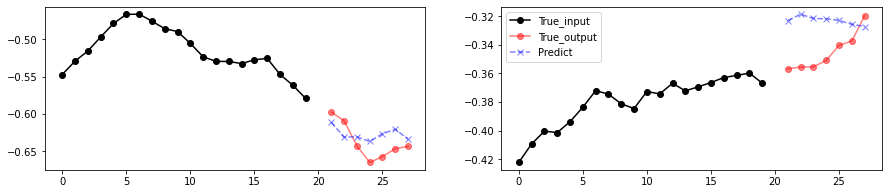

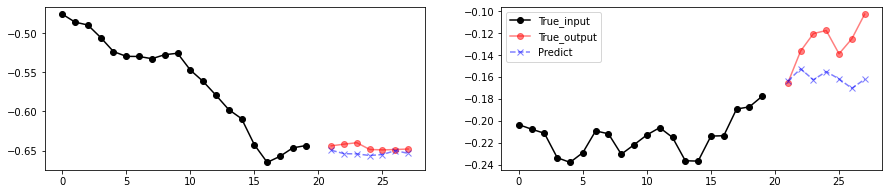

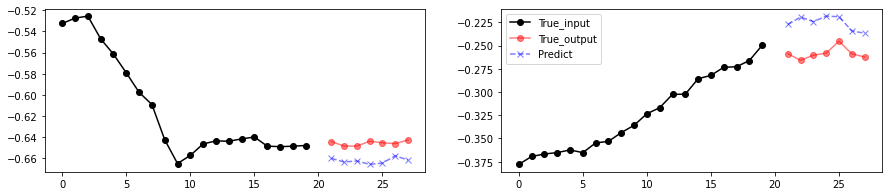

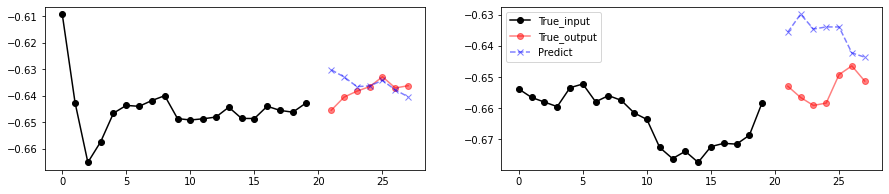

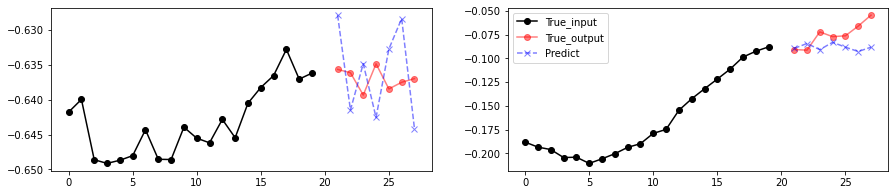

In [64]:
valid_trend_pred = model_trend(m_valid_time, m_valid_notime)

for i in range(10):
    i = i*7
    plt.figure(figsize = (15, 3))
    
    plt.subplot(1,2,1)
    plt.plot(np.arange(20),m_train_time.cpu().detach().numpy()[i,:,-2],
             marker = 'o', color = 'black', label = 'True_input')
    plt.plot(np.arange(21,28),m_train_y[:,:,0].cpu().detach().numpy()[i],
             marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
    plt.plot(np.arange(21,28),train_trend_pred.cpu().detach().numpy()[i],
             color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
    
    plt.subplot(1,2,2)
    plt.plot(np.arange(20),m_valid_time.cpu().detach().numpy()[i,:,-2],
             marker = 'o', color = 'black', label = 'True_input')
    plt.plot(np.arange(21,28),m_valid_y[:,:,0].cpu().detach().numpy()[i],
             marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
    plt.plot(np.arange(21,28),valid_trend_pred.cpu().detach().numpy()[i],
             color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
    
    plt.legend()
    plt.show()

In [55]:
#hidden state : 전달과정 중간 출력의 차원
model_cycle = LSTMModel_trend(input_size = 10, hidden_size = 32, no_time_size = 3).to(device)
optimizer = torch.optim.Adam(model_cycle.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

# Train model
#####################
num_epochs  = 300
hist = np.zeros(num_epochs)

# Number of steps to unroll
look_back = 21
seq_dim =look_back - 1  

train_error = []
valid_error = []

early_stop = 0
patient = 0

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass

    # train error
    train_cycle_pred = model_cycle(train_time, train_notime)
    loss = criterion(train_cycle_pred, train_y[:,:,1])
    train_error.append(loss)
    
    # valid error
    valid_cycle_pred = model_cycle(valid_time, valid_notime)
    valid_mse = float(criterion(valid_cycle_pred, valid_y[:,:,1]).cpu())
    valid_error.append(valid_mse)
    
    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimizer.step()
    
    if t % 4 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

4 Epochs train MSE: 0.10170 // valid MSE: 0.09965
8 Epochs train MSE: 0.09351 // valid MSE: 0.09055
12 Epochs train MSE: 0.09231 // valid MSE: 0.09089
16 Epochs train MSE: 0.08732 // valid MSE: 0.08910
20 Epochs train MSE: 0.07720 // valid MSE: 0.08388
24 Epochs train MSE: 0.06671 // valid MSE: 0.08194
28 Epochs train MSE: 0.05309 // valid MSE: 0.08057
32 Epochs train MSE: 0.04259 // valid MSE: 0.07495
36 Epochs train MSE: 0.03743 // valid MSE: 0.07796
40 Epochs train MSE: 0.03179 // valid MSE: 0.08144
44 Epochs train MSE: 0.02793 // valid MSE: 0.08082
48 Epochs train MSE: 0.02548 // valid MSE: 0.07946
52 Epochs train MSE: 0.02370 // valid MSE: 0.07341
56 Epochs train MSE: 0.02196 // valid MSE: 0.07046
60 Epochs train MSE: 0.02076 // valid MSE: 0.06708
64 Epochs train MSE: 0.01975 // valid MSE: 0.06548
68 Epochs train MSE: 0.01876 // valid MSE: 0.06570
72 Epochs train MSE: 0.01787 // valid MSE: 0.06568
76 Epochs train MSE: 0.01705 // valid MSE: 0.06611
80 Epochs train MSE: 0.01679 // v

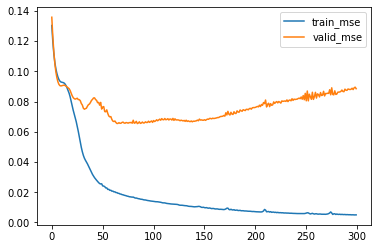

In [56]:
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.xticks(label = 'epochs')
plt.legend()
plt.show()

In [36]:
m_train_time = torch.FloatTensor(e_train_time[:,:,2:]).to(device)
m_train_notime = torch.FloatTensor(e_train_notime).to(device)
m_train_y = torch.FloatTensor(e_train_y).to(device)
 
m_valid_time = torch.FloatTensor(e_valid_time[:,:,2:]).to(device)
m_valid_notime = torch.FloatTensor(e_valid_notime).to(device)
m_valid_y = torch.FloatTensor(e_valid_y).to(device)

In [66]:
#hidden state : 전달과정 중간 출력의 차원
model_cycle = LSTMModel_trend(input_size = 10, hidden_size = 32, no_time_size = 3).to(device)
optimizer = torch.optim.Adam(model_cycle.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

# Train model
#####################
num_epochs  = 300
hist = np.zeros(num_epochs)

# Number of steps to unroll
look_back = 21
seq_dim =look_back - 1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass

    # train error
    train_cycle_pred = model_cycle(m_train_time, m_train_notime)
    loss = criterion(train_cycle_pred, m_train_y[:,:,1])
    train_error.append(loss)
    
    # valid error
    valid_cycle_pred = model_cycle(m_valid_time, m_valid_notime)
    valid_mse = float(criterion(valid_cycle_pred, m_valid_y[:,:,1]).cpu())
    valid_error.append(valid_mse)
    
    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimizer.step()
    
    if t % 4 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

4 Epochs train MSE: 0.05343 // valid MSE: 0.03680
8 Epochs train MSE: 0.04399 // valid MSE: 0.02577
12 Epochs train MSE: 0.04117 // valid MSE: 0.02328
16 Epochs train MSE: 0.04092 // valid MSE: 0.02355
20 Epochs train MSE: 0.03921 // valid MSE: 0.02325
24 Epochs train MSE: 0.03677 // valid MSE: 0.02395
28 Epochs train MSE: 0.03373 // valid MSE: 0.02359
32 Epochs train MSE: 0.03052 // valid MSE: 0.02111
36 Epochs train MSE: 0.02710 // valid MSE: 0.01841
40 Epochs train MSE: 0.02393 // valid MSE: 0.01745
44 Epochs train MSE: 0.02058 // valid MSE: 0.01732
48 Epochs train MSE: 0.01771 // valid MSE: 0.01671
52 Epochs train MSE: 0.01549 // valid MSE: 0.01653
56 Epochs train MSE: 0.01353 // valid MSE: 0.01593
60 Epochs train MSE: 0.01173 // valid MSE: 0.01622
64 Epochs train MSE: 0.01047 // valid MSE: 0.01526
68 Epochs train MSE: 0.00928 // valid MSE: 0.01533
72 Epochs train MSE: 0.00861 // valid MSE: 0.01524
76 Epochs train MSE: 0.00790 // valid MSE: 0.01628
80 Epochs train MSE: 0.00698 // v

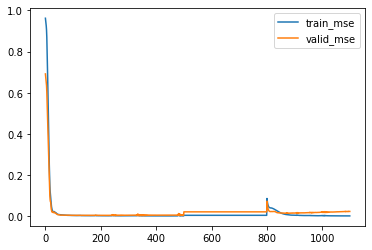

In [67]:
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.xticks(label = 'epochs')
plt.legend()
plt.show()

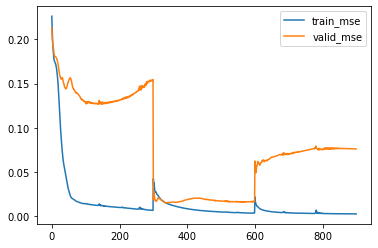

In [38]:
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.xticks(label = 'epochs')
plt.legend()
plt.show()

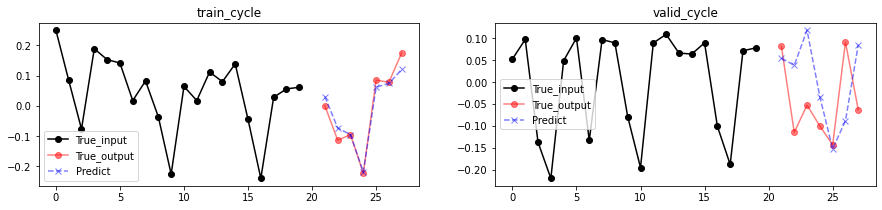

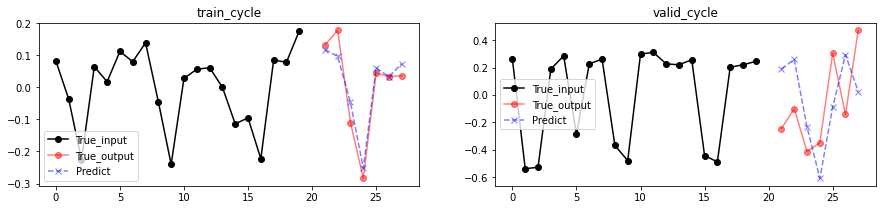

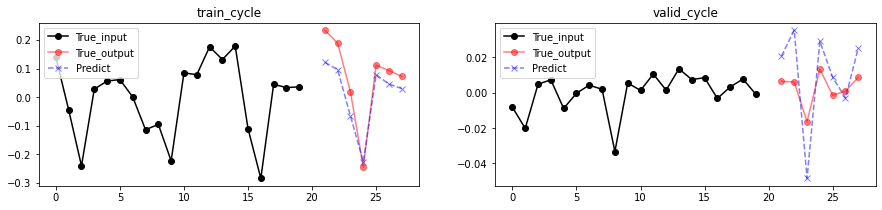

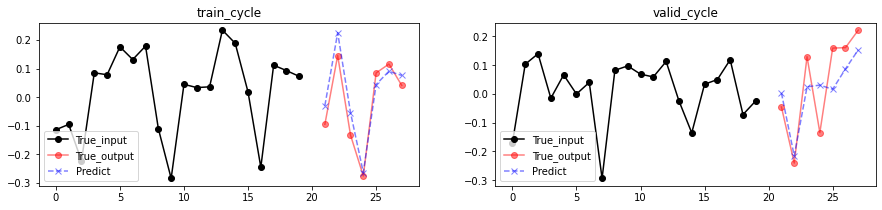

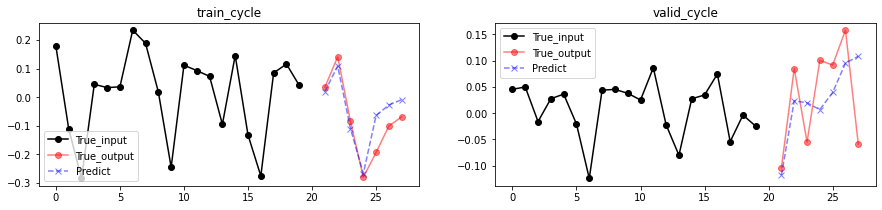

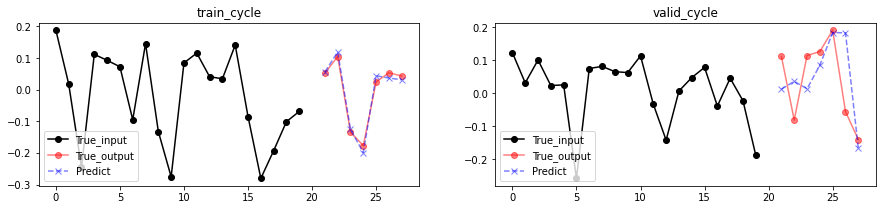

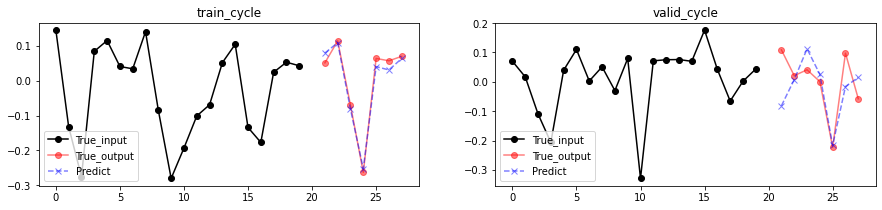

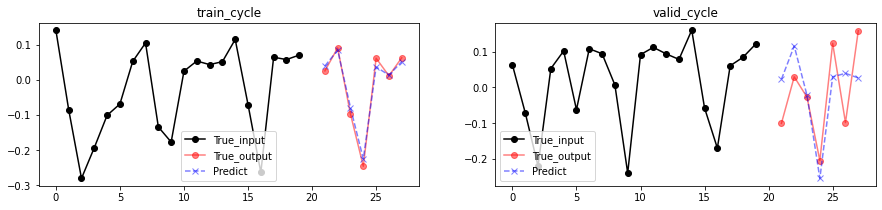

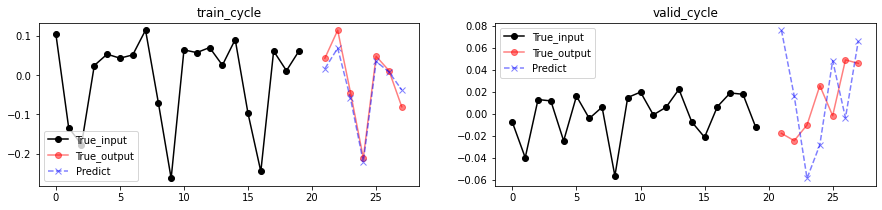

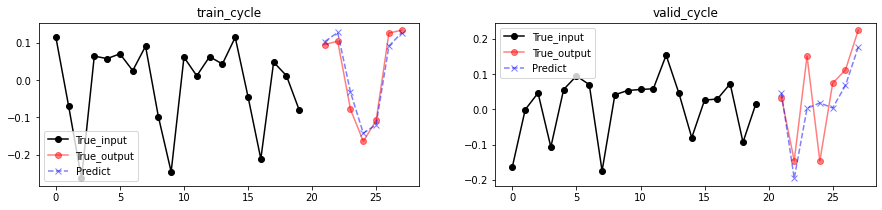

In [39]:
valid_cycle_pred = model_cycle(m_valid_time, m_valid_notime)

for i in range(10):
    i = i*7
    plt.figure(figsize = (15, 3))
    plt.subplot(1,2,1)
    plt.plot(np.arange(20),m_train_time.cpu().detach().numpy()[i,:,-1],
             marker = 'o', color = 'black', label = 'True_input')
    plt.plot(np.arange(21,28),m_train_y[:,:,1].cpu().detach().numpy()[i],
             marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
    plt.plot(np.arange(21,28),train_cycle_pred.cpu().detach().numpy()[i],
             color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
    plt.title('train_cycle')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(20),m_valid_time.cpu().detach().numpy()[i,:,-1],
             marker = 'o', color = 'black', label = 'True_input')
    plt.plot(np.arange(21,28),m_valid_y[:,:,1].cpu().detach().numpy()[i],
             marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
    plt.plot(np.arange(21,28),valid_cycle_pred.cpu().detach().numpy()[i],
             color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
             
    plt.title('valid_cycle')
    plt.legend()
    plt.show()

In [57]:
def plot_result(data_time, data_y, trend_pred, cycle_pred, i, m_time_scaler = m_time_scaler, inverse_scale = False):
    
    trend_input = data_time[i,:,-2]
    cycle_input = data_time[i,:,-1]

    # true output
    trend_output = data_y[:,:,0][i]
    cycle_output = data_y[:,:,1][i]
 
    # pred output
    trend_pred = trend_pred[i]
    cycle_pred = cycle_pred[i]
   
    if inverse_scale == True:
        trend_input = m_time_scaler.inverse_transform(trend_input, select_col = 0)
        cycle_input = m_time_scaler.inverse_transform(cycle_input, select_col = 0)

        trend_output = m_time_scaler.inverse_transform(trend_output, select_col = 0)
        cycle_output = m_time_scaler.inverse_transform(cycle_output, select_col = 0)

        trend_pred = m_time_scaler.inverse_transform(trend_pred, select_col = 0)
        cycle_pred = m_time_scaler.inverse_transform(cycle_pred, select_col = 0)

    total_input = trend_input +  cycle_input
    total_output = trend_output +  cycle_output
    total_pred = trend_pred + cycle_pred
    
    # input
    '''
    plt.plot(np.arange(20), trend_input,# trend
             marker = 'o', color = 'blue', alpha = 0.2)#, label = 'trend_input')
    plt.plot(np.arange(20), cycle_input, # cycle
             marker = 'o', color = 'red', alpha = 0.2)#, label = 'cycle_input')
    '''
    plt.plot(np.arange(20), total_input, # trend + cycle
             marker = 'o', color = 'black')#, label = 'total_input')
    '''
    # true output
    plt.plot(np.arange(21,28), trend_output,# trend
             marker = 'o', color = 'blue', alpha = 0.2)#, label = 'tend_true')
    plt.plot(np.arange(21,28), cycle_output, # cycle
             marker = 'o', color = 'red', alpha = 0.2)#, label = 'cycle_true')
    '''
    plt.plot(np.arange(21,28), total_output, # trend + cycle
             marker = 'o', color = 'black')#, label = 'total_true')
    '''
    # pred output
    plt.plot(np.arange(21,28), trend_pred,# trend
             marker = 'o', color = 'blue', alpha = 0.2, ls = 'dashdot', label = 'trend_pred')
    plt.plot(np.arange(21,28), cycle_pred, # cycle
             marker = 'o', color = 'red', alpha = 0.2, ls = 'dashdot',label = 'cycle_pred')
    '''
    plt.plot(np.arange(21,28), total_pred, # trend + cycle
             marker = 'o', color = 'brown', ls = 'dashdot',label = 'total_pred')

In [54]:
m_train_time = m_train_time.cpu().detach().numpy()
m_train_y = m_train_y.cpu().detach().numpy()
train_trend_pred = train_trend_pred.cpu().detach().numpy()
train_cycle_pred = train_cycle_pred.cpu().detach().numpy()

m_valid_time = m_valid_time.cpu().detach().numpy()
m_valid_y = m_valid_y.cpu().detach().numpy()
valid_trend_pred = valid_trend_pred.cpu().detach().numpy()
valid_cycle_pred = valid_cycle_pred.cpu().detach().numpy()

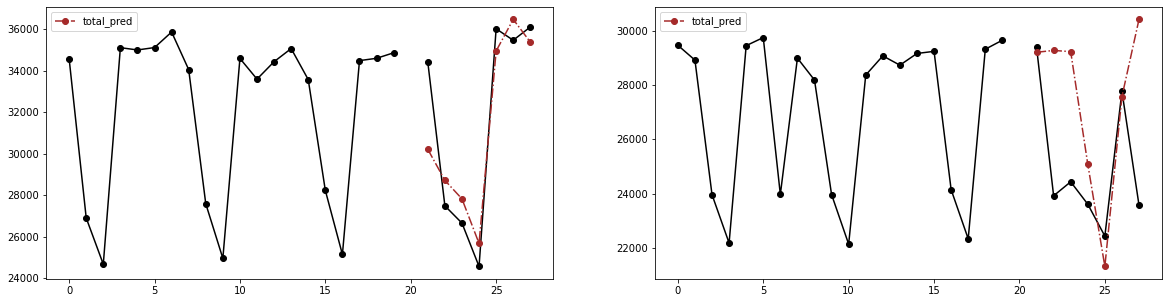

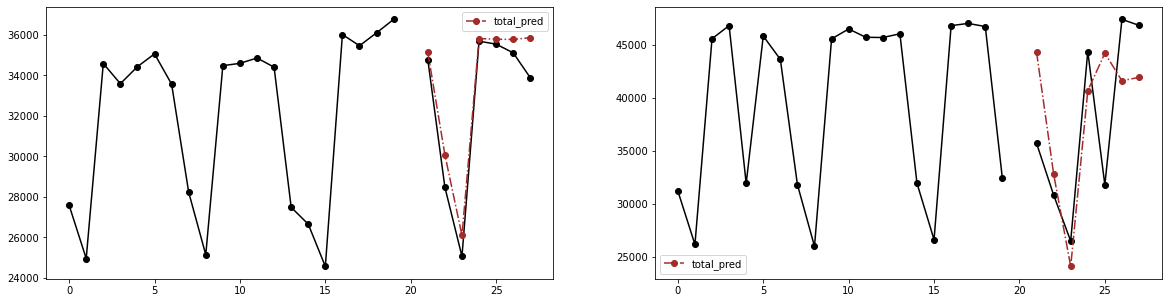

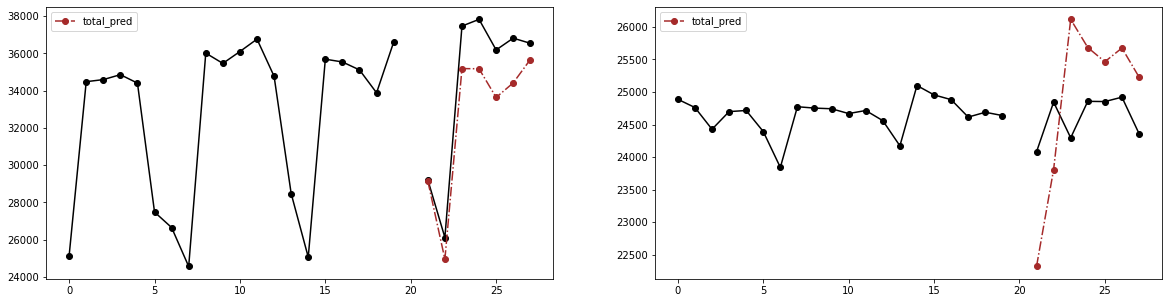

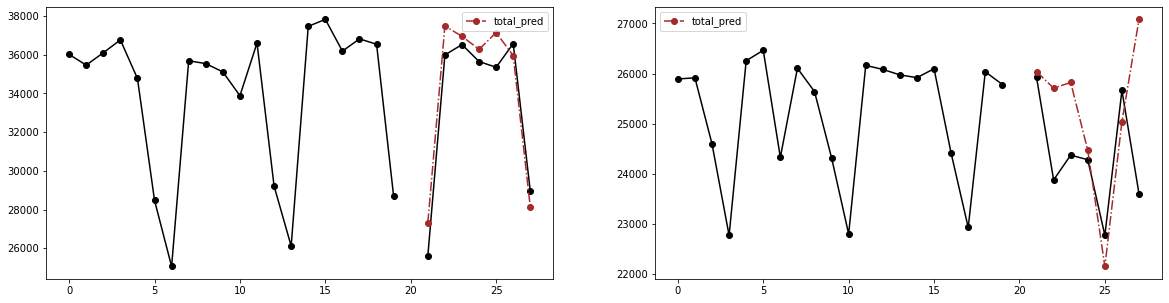

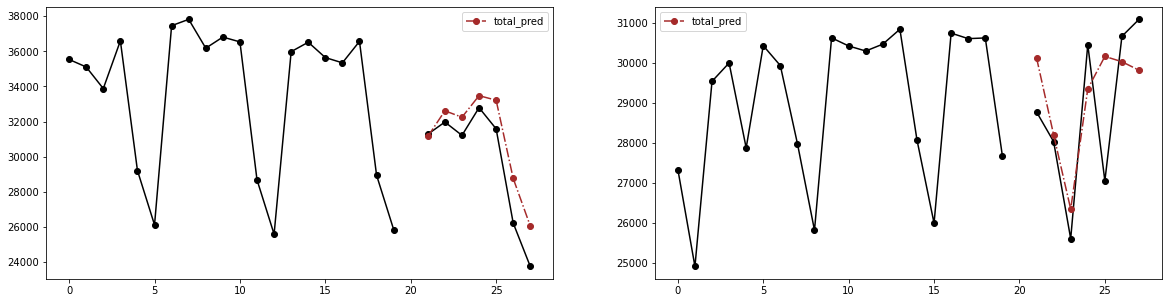

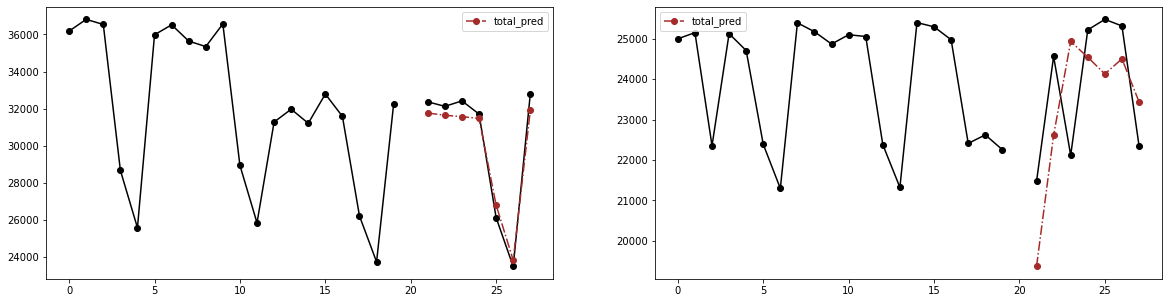

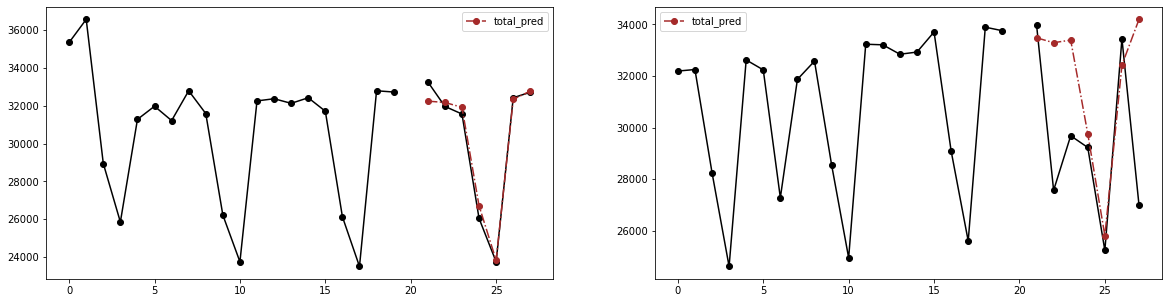

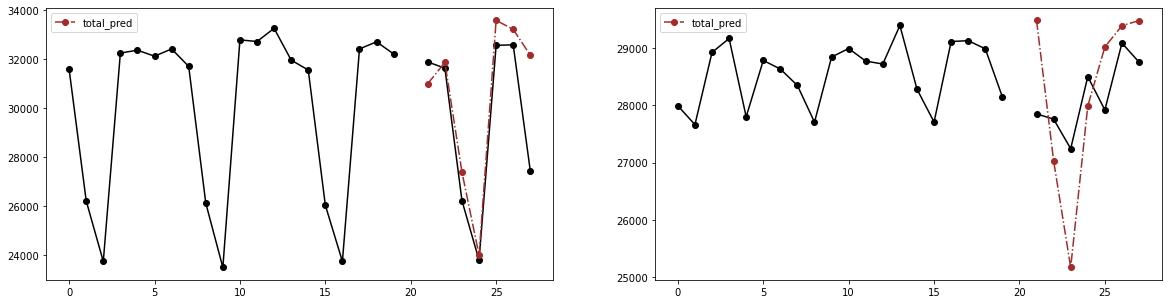

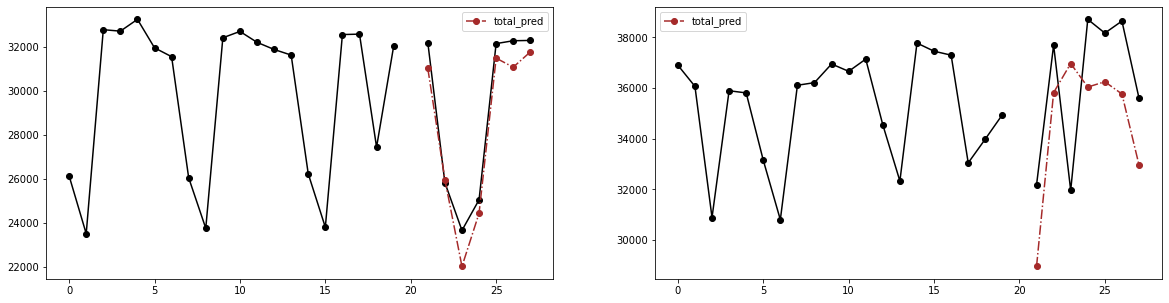

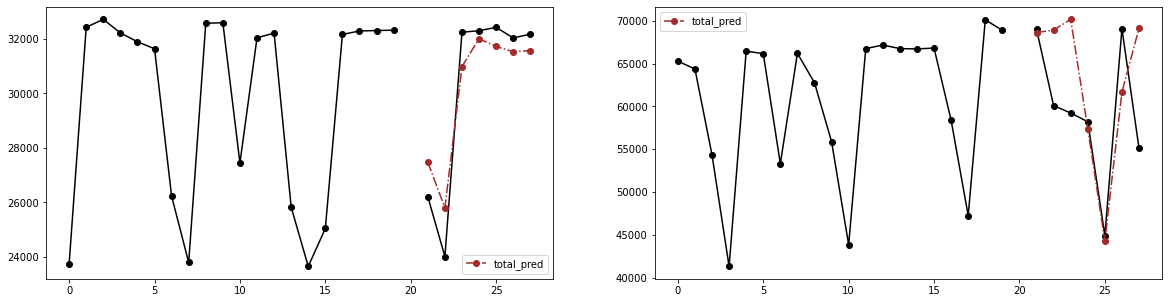

In [59]:
for i in range(10):
    i = i*8
    plt.figure(figsize = (20, 5))
    plt.subplot(1,2,1)
    plot_result(m_train_time, m_train_y, train_trend_pred, train_cycle_pred, i, inverse_scale=True)
    plt.legend()

    plt.subplot(1,2,2)
    plot_result(m_valid_time, m_valid_y, valid_trend_pred, valid_cycle_pred, i, inverse_scale=True)
    plt.legend()
    plt.show()